In [2]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import datetime 
from scipy import optimize
from scipy.optimize import root
#plt.style.use('seaborn')  # sets the plotting style

In [3]:
# Parameters taken from paper, p.15 (new version: p.37)
mu = 0.042
r=mu
mu_y = -0.0492
sigma_y = 2.061
l = 0.0515
alpha = 0.0102
beta = -0.188
rho = 0.275
sigma_v = 0.007
rho_j = 0 #-0.210 try  new  assumption
mu_v = 0.709
v0 = 0.19**2 # email Lili Matic 12.7.2019
v0

0.0361

In [4]:
kappa = 1-beta
theta = alpha / kappa
[kappa, theta]

[1.188, 0.008585858585858587]

In [5]:
np.sqrt(theta)/np.sqrt(365)

0.004850041261188301

In [6]:
l/365

0.0001410958904109589

In [7]:
#l = 0
#rho = -0.62
#sigma_v = 0.6
#mu_v = 0.014
#theta = 0.053
#kappa = 1.61

In [8]:
npr.seed(12345)
dt = 1/365 # dt
m = int(365 * (1/dt)/365) # time horizon in days
n=100000
T = m * dt
t = np.arange(0,T+dt, dt)
#dt = t[1]-t[0]
w = npr.standard_normal([n,m])
w2 = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v = npr.exponential(mu_v, [n,m])
z_y = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj = npr.binomial(1, l * dt, size=[n,m])
s = np.zeros([n,m+1])
v = np.zeros([n,m+1])
s0=6500
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0

In [9]:
s0=6500
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]
    
s2=s

/Users/lilimatic/anaconda3/envs/lilisthesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [10]:
s = s2/s0 * 100

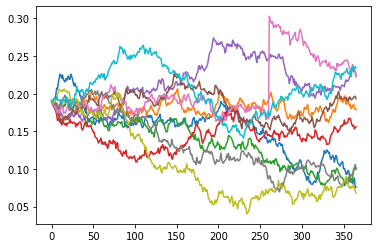

In [11]:
plt.plot(np.transpose(sp.sqrt(v[:10])));

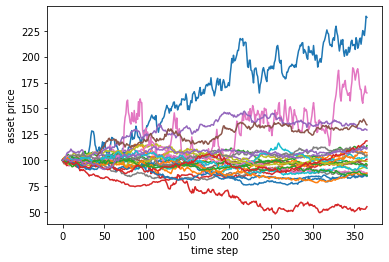

In [40]:
plt.plot(np.transpose(s[94:119]));
plt.xlabel('time step')
plt.ylabel('asset price')
plt.savefig('assetpathssvcj.png',transparent=T)

In [41]:
119-94

25

In [13]:
m * dt

1.0

In [14]:
k=6500;
cp = np.exp(-mu * m * dt) * np.maximum(s[:,-1]-k,0).mean()
cp

0.0

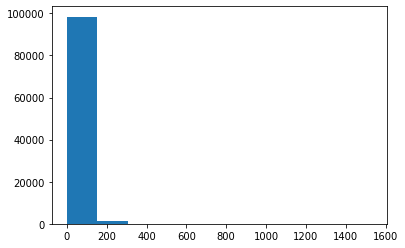

In [15]:
plt.hist(s[:,-1]);

For the price process to be a martingale (=risk-neutral), this should be approximately $S_0$ (6500).

In [ ]:
np.exp(-mu * m *dt) * s[:,-1].mean()

Implied volatility

In [ ]:
def callprice(S,K,T,sigma,r):
    d1=(sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    d2=(sp.log(S/K) + (r - 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S*scs.norm.cdf(d1) - sp.exp(-r *T) * K * scs.norm.cdf(d2)

def delta(S, K, T, sigma, r):
    d1=(math.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * math.sqrt(T))
    return scs.norm.cdf(d1) 

def gamma(S, K, T, sigma, r):
    d1=(math.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * math.sqrt(T))
    return scs.norm.pdf(d1) / (S * sigma * math.sqrt(T))

def vega(S, K, T, sigma, r):
    d1=(math.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * math.sqrt(T))
    return S * math.sqrt(T) * scs.norm.pdf(d1)

In [ ]:
callprice(100,100,1,0.2,0.05)

In [ ]:
def solve(sigma, cp, k, T):
    return (callprice(100, k, T, sigma, r) - cp)**2

result = sp.optimize.minimize(solve, 0.2, args=(cp, k, T))
result

In [ ]:
callprice(s0, k, T, result.x[0], mu)

Normalise everything to $S_0=100$

In [ ]:
s = s2/s0 * 100

In [ ]:
def call_and_vol(K, T): # T maturity in years
    m = int(np.round(T / dt))
    cp = np.exp(-r * m * dt) * np.maximum(s[:,-1]-K,0).mean()
    iv = sp.optimize.minimize(solve, 0.4, args=(cp, K,T)).x[0]
    return [cp, iv]

In [ ]:
[call_and_vol(120,0.5), callprice(100, 120, 0.5, 0.98, r)]

From here on we do everything on $S_0=100$

In [ ]:
strike = np.arange(.7, 1.3, 0.1)*100
ttm = np.arange(30, 360, 30)/360
print(len(strike))
strike, ttm = np.meshgrid(strike, ttm)
strike.shape

In [ ]:
h5 = pd.HDFStore('dawp/python36/08_m76/option_data.h5', 'r')
data = h5['data']  # European call & put option data (3 maturities)
h5.close()

type(data)

data.info()

data.head()

In [ ]:
iv = np.zeros(strike.shape)
call = np.zeros(strike.shape)
df = pd.DataFrame(columns=data.columns)
i=0
date = datetime.date(2019, 7, 4)
for k in range(strike.shape[1]):
    for t in range(strike.shape[0]):
        [x, y] = call_and_vol(strike[t,k], ttm[t,k])
        iv[t,k] = y
        call[t,k] = x
        df.loc[i] = [date, strike[t,k], x, date + datetime.timedelta(days=ttm[t,k]*365), 0]
        i+=1

In [ ]:
df.info()

In [ ]:
df2 = df[(df['Strike'] > 90.0) & (df['Strike'] < 105.0)] ## restrict to ATM options

In [ ]:
df.to_csv('callprices.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(12, 7)) 
ax = fig.gca(projection='3d')   # set up canvas for 3D plotting
surf = ax.plot_surface(strike/100, ttm, iv, rstride=3, cstride=3,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)  # creates 3D plot
ax.view_init(30, 30)
ax.set_xlabel('moneyness')  
ax.set_ylabel('time-to-maturity')  
ax.set_zlabel('implied volatility')  
fig.colorbar(surf, shrink=0.5, aspect=5);
plt.savefig('SVCJ_volsurface.png', transparent=T)

In [ ]:
#compute Black-Scholes calibrated parameter using Levenberg Marquant
#FFT BASED done as well
def solve_bs(sigma):
    return (callprice(100, df['Strike'], ttm.reshape(77), sigma, r) - df['Call'])**2

impliedvol = optimize.root(solve_bs,2, method='lm').x
#impliedvol

In [128]:
callprice(100, df['Strike'], ttm.reshape(77), impliedvol, r) - df['Call']

0    -4.460028
1    -4.336453
2    -4.217284
3    -4.094573
4    -3.976237
        ...   
72    1.954160
73    1.959023
74    1.964031
75    1.968861
76    1.973834
Length: 77, dtype: float64

In [ ]:


def call_and_conf(K, T): # T maturity in years
    m = int(np.round(T / dt))
    cp = np.exp(-r * m * dt) * np.maximum(s[:,-1]-K,0).mean()
    iv = sp.optimize.minimize(solve, 0.4, args=(cp, K,T)).x[0]
    a = np.exp(-r * m * dt) * np.maximum(s[:,-1]-K,0)
    ci = [scs.norm.interval(0.95, loc=np.mean(a), scale=scs.sem(a))]
    return [cp, iv,ci]

iv = np.zeros(strike.shape)
call = np.zeros(strike.shape)
df = pd.DataFrame(columns=data.columns)
KI  = np.zeros(strike.shape)
i=0
date = datetime.date(2019, 8, 28)
for k in range(strike.shape[1]):
    for t in range(strike.shape[0]):
        [x, y,z] = call_and_conf(strike[t,k], ttm[t,k])
        iv[t,k] = y
        call[t,k] = x
        df.loc[i] = [date, strike[t,k], x, date + datetime.timedelta(days=ttm[t,k]*365), z]
        i+=1

In [ ]:
df
df = df[['Call', 'Put', 'Strike', 'Date', 'Maturity']]

In [91]:
df.columns = ['Call', '95 %  Confidence Interval', 'Strike', 'Issuing Date', 'Maturity']
df2 = df[(df['Strike'] > 90.0) & (df['Strike'] < 105.0)] ## restrict to ATM options

In [92]:
#df
df2.to_csv('callpricesconf95.csv', index=False)

## Merton Jump Diffusion stuff

In [93]:
import sys
sys.path.insert(0, 'dawp/python36/08_m76/')

from M76_valuation_FFT import M76_value_call_FFT

In [137]:
S0 = 100.0  # initial index level
K = 100.0  # strike level
T = 1  # call option maturity
r = 0.042  # constant short rate

sigma = 0.946 
lamb = 1
mu = 0.5 
delta = 0.5

sigma = 0.797 
lamb = 62.315
mu = 0.064
delta = 0.

#sigma = 1.024 
#lamb = 0.000 
#mu = 4.776 
#delta = 0.000

#sigma = 0.2
#r = 0.02
#lamb = 0.1
#mu = -0.05
#delta = np.sqrt(0.1)

sigma = 0.931 
lamb = 8.140 
mu = 0.059 
delta = 0.000

sigma = 0.000 
lamb = 6.368 
mu = -0.104 
delta = 0.063

sigma = 0.000 
lamb = 5.191
mu = -0.081
delta = 0.110

In [40]:
call_and_vol(strike[5,5], ttm[5,5])

[2.5061372714503753, 0.28000586067558714]

In [41]:
[call_and_vol(120,0.5), callprice(100, 120, 0.5, 0.98, r)]

[[2.5061372714503714, 0.2800058606755919], 21.482830852100697]

In [42]:
#for k in range(strike.shape[1]):
#    for t in range(strike.shape[0]):
#        print(M76_value_call_FFT(100,strike[t,k],ttm[t,k],r,sigma,lamb,mu,delta)-call[t,k])

In [43]:
sp.optimize.minimize(solve, 1, args=(21.4931819, strike[5,5],ttm[5,5])).x[0]

0.9803693171459932

In [44]:
sp.optimize.minimize?

In [143]:
def call_and_vol_mjd(K, T): # T maturity in years
    cp = M76_value_call_FFT(100,K,T,r,sigma,lamb,mu,delta) 
    iv = sp.optimize.minimize(solve,0.5, args=(cp, K,T)).x[0]
    return [cp, iv]

In [144]:
call_and_vol_mjd(strike[10,6], ttm[10,5])

[2.9945652895825483, 0.2672768127713153]

In [46]:
iv_mjd = np.zeros(strike.shape)
call_mjd = np.zeros(strike.shape)
i=0
date = datetime.date(2019, 7, 4)
for k in range(strike.shape[1]):
    for t in range(strike.shape[0]):
        [x, y] = call_and_vol_mjd(strike[t,k], ttm[t,k])
        iv_mjd[t,k] = y
        call_mjd[t,k] = x
        i+=1

np.sqrt(((call_mjd-call)**2).sum()/(strike.shape[0]*strike.shape[1]))

NameError: name 'call_and_vol_mjd' is not defined

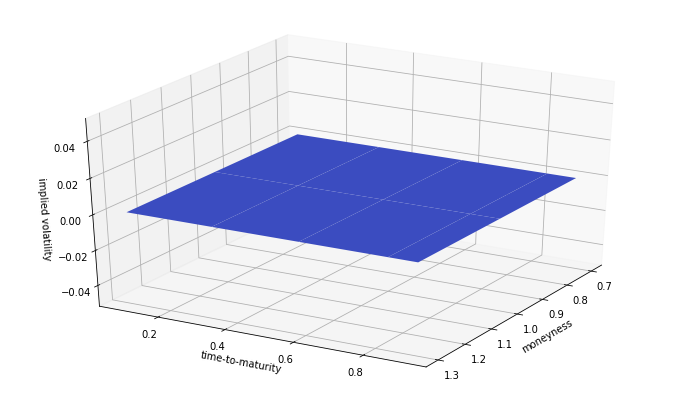

In [47]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(12, 7)) 
ax = fig.gca(projection='3d')   # set up canvas for 3D plotting
surf = ax.plot_surface(strike/100, ttm, iv_mjd, rstride=3, cstride=3,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)  # creates 3D plot
ax.view_init(30, 30)
ax.set_xlabel('moneyness')  
ax.set_ylabel('time-to-maturity')  
ax.set_zlabel('implied volatility')  
#fig.colorbar(surf, shrink=0.5, aspect=5);
plt.savefig('MJD_volsurface.png',  transparent= T)

## Heston stuff

In [57]:
import sys

sys.path.append('dawp/python36/11_cal/')
sys.path.append('dawp/python36/09_gmm')
sys.path.append('dawp/python36/10_mcs')
%run dawp/python36/11_cal/H93_calibration.py

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [58]:
%time opt_sv = H93_calibration_full()

   0 | [87.357 0.005 0.916 -0.907 4.179] |   2.009 |   2.009
  25 | [88.309 0.005 0.911 -0.918 4.059] |   1.972 |   1.964
  50 | [87.957 0.005 0.943 -0.922 3.896] |   1.956 |   1.956
  75 | [86.780 0.005 0.928 -0.947 3.839] |   1.951 |   1.951
 100 | [85.619 0.005 0.926 -0.976 3.758] |   1.948 |   1.948
 125 | [85.447 0.005 0.926 -0.979 3.752] |   1.947 |   1.947
 150 | [84.682 0.005 0.930 -0.994 3.754] |   1.944 |   1.944
 175 | [84.477 0.005 0.930 -1.000 3.742] |   1.943 |   1.943
 200 | [84.368 0.005 0.926 -1.000 3.751] |   1.943 |   1.943
 225 | [84.296 0.005 0.918 -0.999 3.751] |   1.942 |   1.942
 250 | [84.234 0.005 0.917 -1.000 3.752] |   1.942 |   1.942
 275 | [84.221 0.005 0.917 -1.000 3.753] |   1.942 |   1.942
 300 | [84.212 0.005 0.917 -1.000 3.754] |   1.942 |   1.942
 325 | [84.216 0.005 0.917 -1.000 3.753] |   1.942 |   1.942
 350 | [84.216 0.005 0.917 -1.000 3.753] |   1.942 |   1.942
 375 | [84.216 0.005 0.917 -1.000 3.753] |   1.942 |   1.942
 400 | [84.216 0.005 0.9

The parameters are: 

* kappa_v
* theta_v
* sigma_v
* rho
* v0

In [149]:
opt_sv 

array([90.658, 0.005, 0.956, -1.000, 4.018])

In [150]:
df['Heston'] = H93_calculate_model_values(opt_sv)

In [151]:
df.head()

,Date,Strike,Call,Maturity,Put,Heston
0,2019-07-04,70.0,34.682141,2019-08-03,0,30.627236
1,2019-07-04,70.0,34.560965,2019-09-02,0,30.868127
2,2019-07-04,70.0,34.440213,2019-10-03,0,31.119465
3,2019-07-04,70.0,34.319883,2019-11-02,0,31.365722
4,2019-07-04,70.0,34.199974,2019-12-03,0,31.623189


In [152]:
df.tail()

,Date,Strike,Call,Maturity,Put,Heston
72,2019-07-04,130.0,1.385416,2020-02-01,0,1.552021
73,2019-07-04,130.0,1.380575,2020-03-03,0,1.635534
74,2019-07-04,130.0,1.375752,2020-04-02,0,1.719692
75,2019-07-04,130.0,1.370945,2020-05-03,0,1.810178
76,2019-07-04,130.0,1.366155,2020-06-02,0,1.901225


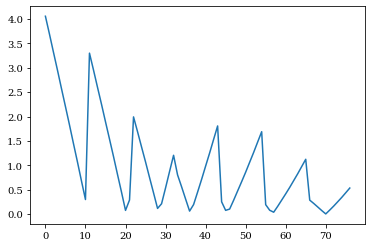

In [153]:
plt.plot(np.abs(df['Call']-df['Heston']))

In [154]:
def call_and_vol_heston(K, T): # T maturity in years
    cp = df[(df['Maturity'] == date + datetime.timedelta(days = T*365)) & (df['Strike']>K-1) & (df['Strike']<K+1)]['Heston'].iloc[0]
    iv = sp.optimize.minimize(solve, 0.5, args=(cp, K,T)).x[0]
    return [cp, iv]

In [155]:
call_and_vol_heston(strike[5,5], ttm[5,5])

[2.960924899028072, 0.3003770742242591]

In [156]:
iv_h = np.zeros(strike.shape)
call_h = np.zeros(strike.shape)
i=0
date = datetime.date(2019, 7, 4)
for k in range(strike.shape[1]):
    for t in range(strike.shape[0]):
        [x, y] = call_and_vol_heston(strike[t,k], ttm[t,k])
        iv_h[t,k] = y
        call_h[t,k] = x
        i+=1

np.sqrt(((call_h-call)**2).sum()/(strike.shape[0]*strike.shape[1]))

1.3751478712881977

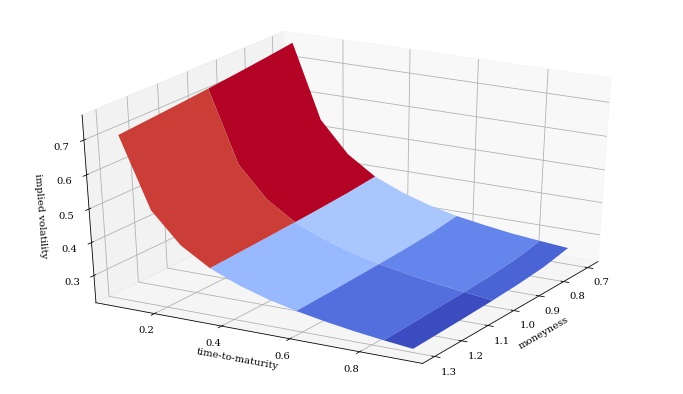

In [160]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(12, 7)) 
ax = fig.gca(projection='3d')   # set up canvas for 3D plotting
surf = ax.plot_surface(strike/100, ttm, iv_h, rstride=3, cstride=3,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)  # creates 3D plot
ax.view_init(30, 30)
ax.set_xlabel('moneyness')  
ax.set_ylabel('time-to-maturity')  
ax.set_zlabel('implied volatility')  
#fig.colorbar(surf, shrink=0.5, aspect=5);
plt.savefig('heston_volsurface.png', transparent = T)